# Biochemical cycles
This notebook descrbies how to create and simulate bond graph models of simple biochemical cycles.

First, import the dependencies for this notebook.

In [1]:
import BondGraphTools as bgt
from matplotlib import pyplot as plt
import numpy as np

from general import mpl_settings, save_figure
from plot_options import set_color_palette

In [2]:
mpl_settings()
set_color_palette()

## Closed biochemical cycle
The reaction network $X \rightleftharpoons Y \rightleftharpoons Z \rightleftharpoons X$ can be represented by the bond graph below:
<img src="closed_biochemical_cycle.png" alt="drawing" width="300"/>

The code below constructs the above bond graph by using a function. The bond graph model uses the parameters $K_X = 1$ mM$^{-1}$, $K_Y = 2$ mM$^{-1}$, $K_Z = 3$ mM$^{-1}$, $r_1 = 1$ mM/s, $r_2 = 2$ mM/s and $r_3 = 3$ mM/s.

In [3]:
def biochemical_cycle(name="Cycle"):
    R = 8.314
    T = 310.0

    model = bgt.new(name=name)
    X = bgt.new("Ce",name="X",library="BioChem",
                 value={'k':1,'R':R,'T':T})
    Y = bgt.new("Ce",name="Y",library="BioChem",
                 value={'k':2,'R':R,'T':T})
    Z = bgt.new("Ce",name="Z",library="BioChem",
                 value={'k':3,'R':R,'T':T})
    common_X = bgt.new("0",name="X")
    common_Y = bgt.new("0",name="Y")
    common_Z = bgt.new("0",name="Z")
    r1 = bgt.new("Re",name="r1",library="BioChem",
                 value={'r':1,'R':R,'T':T})
    r2 = bgt.new("Re",name="r2",library="BioChem",
                 value={'r':2,'R':R,'T':T})
    r3 = bgt.new("Re",name="r3",library="BioChem",
                 value={'r':3,'R':R,'T':T})
    bgt.add(model,X,Y,Z,common_X,common_Y,common_Z,
            r1,r2,r3)

    bgt.connect(common_X,X) # bond 0
    bgt.connect(common_X,r1) # bond 1
    bgt.connect(r1,common_Y) # bond 2
    bgt.connect(common_Y,Y) # bond 3
    bgt.connect(common_Y,r2) # bond 4
    bgt.connect(r2,common_Z) # bond 5
    bgt.connect(common_Z,Z) # bond 6
    bgt.connect(common_Z,r3) # bond 7
    bgt.connect(r3,common_X) # bond 8
    
    return model

model1 = biochemical_cycle()

The `BondGraphTools.draw` function will output a visual representation of the bond graph.

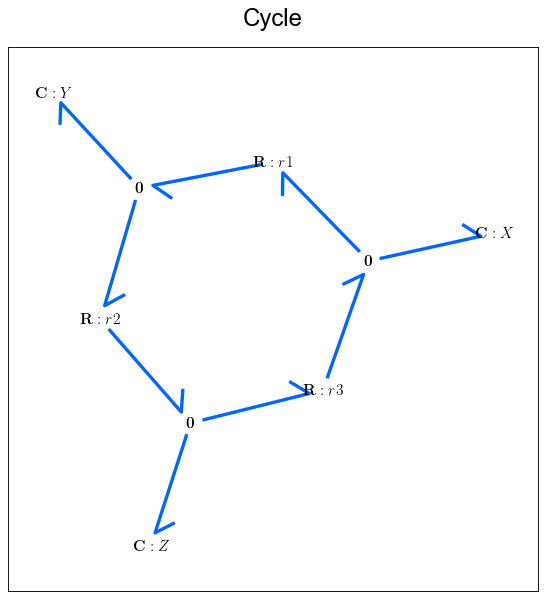

In [4]:
bgt.draw(model1)

The `.constitutive_relations` method will return the equations of the model. Here, `x_0`, `x_1` and `x_2` refer to $x_X$, $x_Y$ and $x_Z$ respectively.

In [5]:
model1.constitutive_relations

[dx_0 + 4*x_0 - 2*x_1 - 9*x_2,
 dx_1 - x_0 + 6*x_1 - 6*x_2,
 dx_2 - 3*x_0 - 4*x_1 + 15*x_2]

The code below simulates the model from $t=0$ seconds to $t=1$ seconds, varying the parameter $K_X$ from 1 to 4.

In [6]:
x0 = [2.0,2.0,2.0]
tspan = (0,1.0)
K_X_vals = [1.0, 2.0, 3.0, 4.0]
sol_t = []
sol_x = []
for K_X in K_X_vals:
    (model1/"C:X").set_param('k',K_X)
    t,x = bgt.simulate(model1,tspan,x0,dt=0.01)
    sol_t.append(t)
    sol_x.append(x)

The fluxes through reaction 1 are plotted against time for each value of $K_X$. Since the bond graph model is thermodynamically consistent, all reaction rates are zero at steady state.

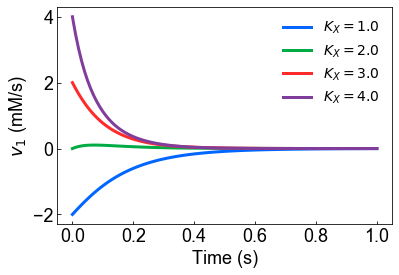

In [7]:
def v1(r,K_X,K_Y,x_X,x_Y):
    return r*K_X*x_X - r*K_Y*x_Y
species = [comp.name for comp,q in model1.state_vars.values()]
i_X = species.index("X")
i_Y = species.index("Y")

fig1 = plt.figure()
for K_X,t,X in zip(K_X_vals,sol_t,sol_x):
    r1 = (model1/"R:r1").params['r']['value']
    K_Y = (model1/"C:Y").params['k']['value']
    r1_fluxes = [v1(r1,K_X,K_Y,x[i_X],x[i_Y]) for x in X]
    plt.plot(t,r1_fluxes,label=f"$K_X = {K_X}$")

plt.xlabel('Time (s)')
plt.ylabel('$v_1$ (mM/s)')
plt.legend()
plt.show()

## Open biochemical cycle
The model above can be modified into an open biochemical cycle with the reactions $X + A \rightleftharpoons Y \rightleftharpoons Z \rightleftharpoons X + B$. Such a reaction network can be represented by the bond graph below.
<img src="open_biochemical_cycle.png" alt="drawing" width="300"/>

This bond graph can be constructed by reusing the bond graph of the closed system, and making the following modifications:
- Disconnecting the 0 junction of the X species from the reactions r1 and r3
- Adding 1 junctions with the chemostats Se:A and Se:B connected
- Connecting the 1 junctions to the 0 junction and reactions r1 and r3

The code below takes this approach to construct a model of the open biochemical cycle.

In [8]:
model2 = biochemical_cycle(name="Open cycle")
r1 = model2/("R:r1")
r3 = model2/("R:r3")
common_X = model2/("0:X")
bgt.disconnect(common_X,r1)
bgt.disconnect(r3,common_X)

R = 8.314
T = 310.0
K_A = 1
x_A = 1
K_B = 2
x_B = 1

A = bgt.new("Se",name="A",
            value={'e':R*T*np.log(K_A*x_A)})
B = bgt.new("Se",name="B",
            value={'e':R*T*np.log(K_B*x_B)})
XA = bgt.new("1",name="XA")
XB = bgt.new("1",name="XB")
bgt.add(model2,A,B,XA,XB)

bgt.connect(common_X,XA)
bgt.connect(A,XA)
bgt.connect(XA,r1)
bgt.connect(r3,XB)
bgt.connect(XB,common_X)
bgt.connect(XB,B)

A computer-generated diagram of the open cycle is below

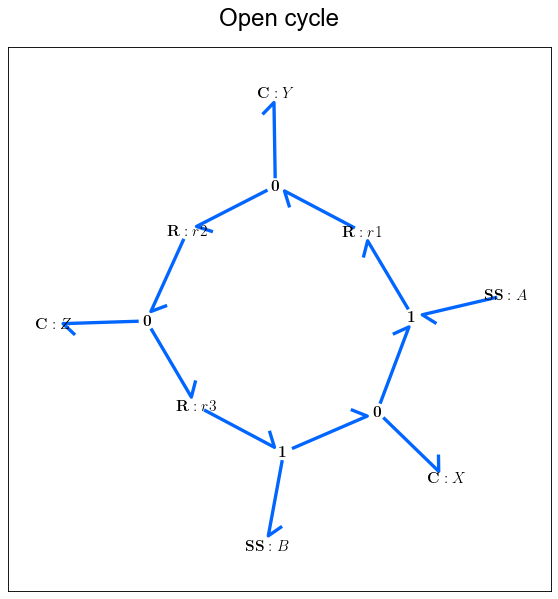

In [9]:
bgt.draw(model2)

In the code below, we simulate the model for different concentrations of A, which changes the free energy of the cycle.

In [10]:
x_A_vals = np.logspace(np.log10(0.02),np.log10(200),51)
K_X = (model2/"C:X").params['k']['value']
K_Y = (model2/"C:Y").params['k']['value']
r1 = (model2/"R:r1").params['r']['value']
mu_B = (model2/"SS:B").params['e']

x0 = [2.0,2.0,2.0]
tspan = (0,10.0)

def v1_open(r,K_X,K_Y,K_A,x_X,x_Y,x_A):
    return r*K_X*x_X*K_A*x_A - r*K_Y*x_Y

affinities = []
fluxes = []

for x_A in x_A_vals:
    mu_A = R*T*np.log(K_A*x_A)
    (model2/"SS:A").set_param('e',mu_A)
    t,x = bgt.simulate(model2,tspan,x0)
    
    affinity = mu_A - mu_B
    affinities.append(affinity)
    
    x_end = x[-1]
    flux = v1_open(r1,K_X,K_Y,K_A,x_end[i_X],x_end[i_Y],x_A)
    fluxes.append(flux)
    
affinities = np.array(affinities)
fluxes = np.array(fluxes)

The steady-state flux is recorded for each concentration of $A$. The affinity of the cycle is plotted against steady-state flux. As expected of a thermodynamically consistent system, the affinity has the same sign as the flux.

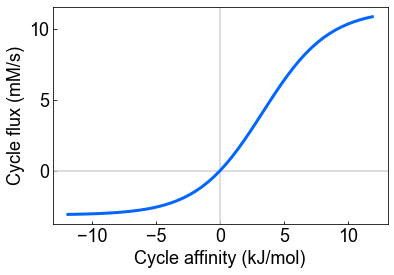

In [11]:
fig2,ax = plt.subplots()
ax.axhline(0, color='lightgray', linewidth=1.5)
ax.axvline(0, color='lightgray', linewidth=1.5)
plt.plot(affinities/1e3,fluxes)
plt.xlabel("Cycle affinity (kJ/mol)")
plt.ylabel("Cycle flux (mM/s)")
plt.show()

Run the code below to save the figures.

In [12]:
save_figure(fig1,"output/biochemical_cycle")
save_figure(fig2,"output/open_biochemical_cycle")